# Age Prediction

In this puzzle, we have to predict the age from the given human faces.

## Setup

- aicrowd-cli: download data and help to make submission
- PyTorch
- albumentations


In [1]:
!pip install aicrowd-cli
%load_ext aicrowd.magic
%aicrowd login

Please login here: https://api.aicrowd.com/auth/MmKwpdFXMo6FP-MaatZNcEbT-wo6JSnf6NQ_-DioyFI
API Key valid
Gitlab access token valid
Saved details successfully!


In [ ]:
!pip install albumentations


## Download Dataset

We will create a folder name data and download the files there.


In [2]:
!mkdir data
%aicrowd ds dl -c age-prediction -o data

test.csv: 100%|██████████| 36.0k/36.0k [00:00<00:00, 255kB/s]
test.zip:   0%|          | 0.00/176M [00:00<?, ?B/s]
train.csv: 100%|██████████| 48.3k/48.3k [00:00<00:00, 213kB/s]

sample_submission.csv: 100%|██████████| 36.0k/36.0k [00:00<00:00, 184kB/s]
val.csv: 100%|██████████| 24.2k/24.2k [00:00<00:00, 602kB/s]
test.zip:   1%|          | 1.05M/176M [00:01<02:55, 998kB/s]
test.zip:   5%|▌         | 9.44M/176M [00:02<00:46, 3.56MB/s]
test.zip:   7%|▋         | 11.5M/176M [00:03<00:39, 4.20MB/s]
test.zip:   8%|▊         | 13.6M/176M [00:04<01:04, 2.52MB/s]
test.zip:   8%|▊         | 14.7M/176M [00:04<00:51, 3.11MB/s]
test.zip:   9%|▉         | 15.7M/176M [00:05<00:50, 3.18MB/s]

test.zip:  10%|▉         | 16.8M/176M [00:05<01:02, 2.54MB/s]

test.zip:  10%|█         | 17.8M/176M [00:06<01:13, 2.16MB/s]

test.zip:  11%|█▏        | 19.9M/176M [00:07<01:07, 2.33MB/s]
test.zip:  12%|█▏        | 22.0M/176M [00:07<00:52, 2.93MB/s]
test.zip:  13%|█▎        | 23.1M/176M [00:07<00:51, 2.97MB/s]



In [3]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

## Importing libraries

In [1]:
# --- General
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm, tqdm_notebook
import cv2


# --- Train
import torch
import torchvision
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2


## Dataset

In [2]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/sample_submission.csv")

In [3]:
display(train_df.head(5))

print(f"Train: {train_df.shape[0]}, Val: {val_df.shape[0]}, Test: {test_df.shape[0]}")

,ImageID,age
0,93vu1,30-40
1,yjifi,80-90
2,ldd2k,90-100
3,eiwe0,40-50
4,sc0bp,0-10


Train: 4000, Val: 2000, Test: 3000


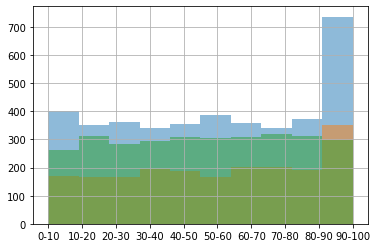

In [4]:
for df in [train_df, val_df, test_df]:
    df.sort_values(by=['age'])['age'].hist(alpha=0.5)

In [6]:
def plot_gallery(title, images, n_col, n_row):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.1 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, img in zip(axs.flat, images):
        img = img - img.min()
        img = img / img.max()
        im = ax.imshow(
            img.permute(1,2,0),
            interpolation="nearest",
        )
        ax.axis("off")
        
    plt.show()

## Preprocessing

In [7]:
# encode age groups 
age_labels = {
    '0-10':  0,
    '10-20': 1,
    '20-30': 2,
    '30-40': 3,
    '40-50': 4,
    '50-60': 5,
    '60-70': 6,
    '70-80': 7,
    '80-90': 8,
    '90-100':9
}

train_df['age'] = train_df['age'].map(age_labels)
val_df['age'] = val_df['age'].map(age_labels)
test_df['age'] = test_df['age'].map(age_labels)

In [23]:
class DatasetLoader(Dataset):

    def __init__(self, df, base_path, transform=None):
        self.df = df
        self.base_path = base_path
        self.file_names = df['ImageID'].values
        self.labels = df['age'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{self.base_path}/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [11]:
transforms = Compose([Resize(400, 400),
                      Normalize(mean=[0.485], std=[0.229]),
                      ToTensorV2()])


## Train model

In [12]:
DEVICE = torch.device("cpu")

In [13]:
def fit_epoch(model, train_loader, objective, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = objective(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, objective):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = objective(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
def train(train_files, val_files, model, epochs, batch_size, learning_rate=3e-4, loss_weights=None):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
        objective = torch.nn.CrossEntropyLoss() 

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, objective, optim)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, objective)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
n_classes = len(age_labels)

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, n_classes)
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
n_epochs = 1
batch_size = 10
lr = 3e-4

train_dataset = DatasetLoader(train_df, './data/train', transform=transforms)
valid_dataset = DatasetLoader(val_df, './data/val', transform=transforms)

history = train(
    train_dataset,
    valid_dataset,
    model=model,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=lr
)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

loss 0.7692197421193123


epoch: 100%|██████████| 1/1 [26:46<00:00, 1606.78s/it]


Epoch 001 train_loss: 0.7692     val_loss 0.6034 train_acc 0.6913 val_acc 0.7400


In [27]:
history

[(0.7692197421193123,
  0.69125,
  0.603363696411252,
  tensor(0.7400, dtype=torch.float64))]

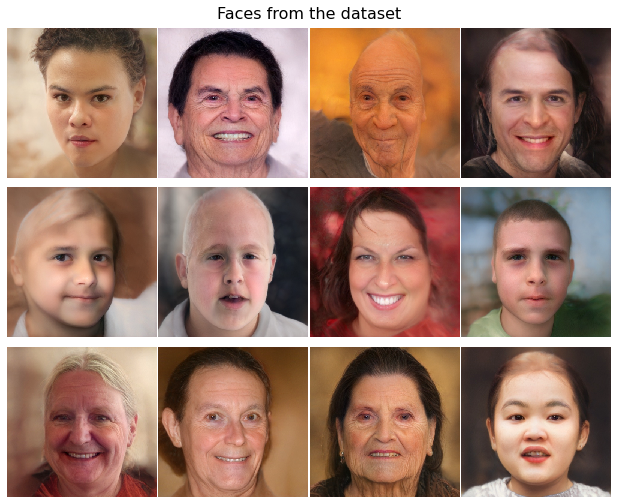

In [90]:
cols = 4
rows = 3
images = [train_dataset[idx][0] for idx in range(cols*rows)]
plot_gallery("Faces from the dataset", images, cols, rows)